Scratch Jupyter Noteboook

In [1]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import tqdm
import nonlinear_approximator as na
from importlib import reload
import torch
import torchvision
import PIL
from pathlib import Path
%matplotlib inline

# Load and Plot MNIST Dataset 

In [2]:
def one_hot_ten(int_label: torch.Tensor) -> NDArray[np.floating]:
    oh = np.zeros((10,))
    oh[int_label] = 1
    return oh

def to_numpy_arr(img: PIL.Image) -> NDArray[np.floating]:
    # rescale 255 to +/- 1 
    arr = np.asarray(img).flatten()
    arr = arr / 255 # 0 --> 1
    arr = arr - .5  # -.5 --> .5
    arr = 2 * arr   # -1 --> 1
    return arr
    
    


In [3]:
train_data = torchvision.datasets.MNIST(root='./data', download=True, train=True, transform=to_numpy_arr, target_transform=one_hot_ten)
test_data = torchvision.datasets.MNIST(root='./data', download=True, train=False, transform=to_numpy_arr, target_transform=one_hot_ten)

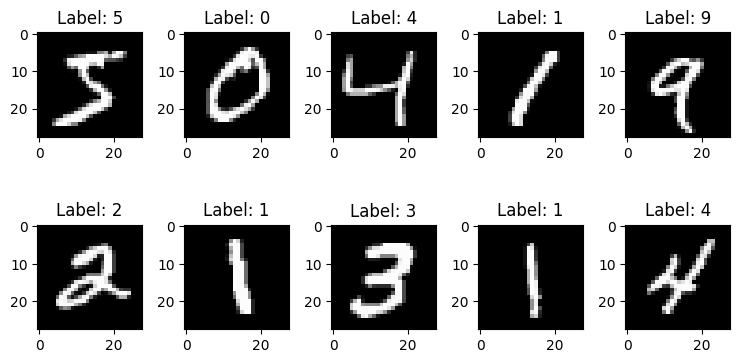

In [4]:
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols,2*num_rows))
for i in range(num_rows*num_cols):
    ax = axes[i//num_cols, i%num_cols]
    ax.imshow(train_data[i][0].reshape((28, 28)), cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(train_data[i][1])))
plt.tight_layout()
plt.show()

# Parameters

In [33]:
reload(na)
reload(na.model)
reload(na.activations)
reload(na.params)
reload(na.training)

import h5py
config = na.params.RegressionParams(
    width=100,
    depth=100,
    input_dimension=len(train_data[0][0]),
    transform_type=na.activations.TransformType.TENT,
    transform_params=na.params.TentParams(mu=1.99),
    output_dimension=len(train_data[0][1]),
    neuron_chunk_size=100,
    storage_path=Path('mnist_data.hdf5'),
    batch_size=10,
)
model = na.model.NonlinearRegressorModel(config)
model.fit(np.zeros((784,200)), np.ones((10,200)))
model.clear_model()

Initializing HDF5 data store at  /home/fritz/untitled/mnist/mnist_data.hdf5


Training on batches:   0%|          | 0/20.0 [00:00<?, ?it/s]












Training on batches:   0%|          | 0/20.0 [00:00<?, ?it/s]

activations shpe:  (100, 100, 10)


ValueError: Mismatch between provided activations with sample count dimension (2) = 10 and target outputs with sample count 100

# Instantiate Model

In [28]:
config.storage_path.absolute()

PosixPath('/home/fritz/untitled/mnist/mnist_data.hdf5')

In [26]:
model = na.model.NonlinearRegressorModel(config)
imgs_train, labels_train = zip(*train_data)
imgs_train = np.asarray(imgs_train).T
labels_train = np.asarray(labels_train).T


imgs_test, labels_test = zip(*test_data)
imgs_test = np.asarray(imgs_test).T
labels_test = np.asarray(labels_test).T

print(f"Loaded training data images with shape {imgs_train.shape}, and labels with shape {labels_train.shape}")
print(f"Loaded test data images with shape {imgs_test.shape}, and labels with shape {labels_test.shape}")

Loaded training data images with shape (784, 60000), and labels with shape (10, 60000)
Loaded test data images with shape (784, 10000), and labels with shape (10, 10000)


In [27]:
model.save()

# Train MNIST Classifier

In [13]:
model.fit(imgs_train[:, :1000], labels_train[:,:1000].T)
probs_train = model.predict(imgs_train[:,:1000])

100%|██████████| 100/100 [00:00<00:00, 382.89it/s]


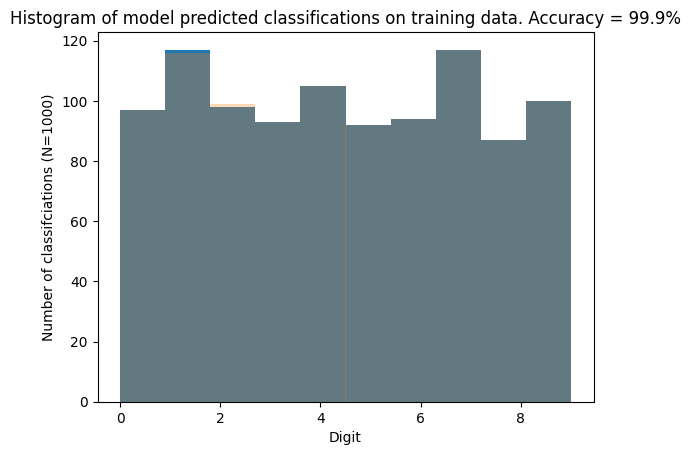

In [14]:
preds_train = probs_train.T.argmax(axis=0)
acc_train = sum(preds_train==labels_train.argmax(axis=0)[:1000]) / len(preds_train)

plt.hist(preds_train, bins=10)
plt.hist(labels_train.argmax(axis=0)[:1000], bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on training data. Accuracy = {100 *acc_train}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_train)})")
plt.show()


100%|██████████| 100/100 [00:00<00:00, 539.39it/s]


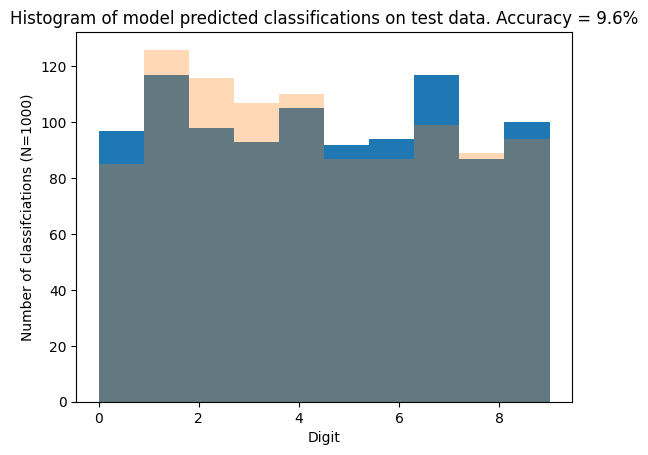

In [15]:
probs_test = model.predict(imgs_train[:,:1000]) 
preds_test = probs_test.T.argmax(axis=0)
acc_test = sum(preds_test==labels_test.argmax(axis=0)[:1000]) / len(preds_test)

plt.hist(preds_test, bins=10)
plt.hist(labels_test.argmax(axis=0)[:1000], bins=10, alpha=0.3)
plt.title(f"Histogram of model predicted classifications on test data. Accuracy = {100 *acc_test}%")
plt.xlabel("Digit")
plt.ylabel(f"Number of classifciations (N={len(preds_test)})")
plt.show()

In [ ]:
xor_thresh = 0.5

xors_train_rounded = outputs.mean(axis=2).copy()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array(
    [xor(train_samples[:, i]) for i in range(train_samples.shape[1])]
)


mask_0 = np.isclose(xors_train_rounded, 0).squeeze()
mask_1 = np.isclose(xors_train_rounded, 1).squeeze()
plt.scatter(
    train_samples[0, mask_0],
    train_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    train_samples[0, mask_1],
    train_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_train_rounded != xor_train_actual).squeeze()
plt.scatter(
    train_samples[0, mask_incorrect],
    train_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()


# Test XOR Approximation

In [ ]:
outputs_test = infer(test_samples, neurons, decoders, config)
#  (D x S) x (D x Y).T @ (D x S) ==> Y x
plt.hist(outputs_test.mean(axis=2).T, 20, density=True)
plt.title(f"Test Eval Output Probability Histogram N={test_samples.shape[1]}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

In [ ]:
xor_thresh = 0.5

xors_test_rounded = outputs_test.mean(axis=2).copy()
xors_test_rounded[xors_test_rounded <= xor_thresh] = 0
xors_test_rounded[xors_test_rounded > xor_thresh] = 1
xors_test_actual = np.array(
    [xor(test_samples[:, i]) for i in range(test_samples.shape[1])]
)


mask_0 = np.isclose(xors_test_rounded, 0).squeeze()
mask_1 = np.isclose(xors_test_rounded, 1).squeeze()
plt.scatter(
    test_samples[0, mask_0],
    test_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    test_samples[0, mask_1],
    test_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_test_rounded != xors_test_actual).squeeze()
plt.scatter(
    test_samples[0, mask_incorrect],
    test_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()